# 薛定谔方程：不同势能下高斯波包的演化

本演示展示了一维薛定谔方程中高斯波包在不同势能函数下的时间演化。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
import warnings
warnings.filterwarnings('ignore')

# 设置绘图参数
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [2]:
def solve_schrodinger_1d(V, x, t_final, num_t=100, hbar=1.0, m=1.0, sigma=0.05, x0=0.5):
    """
    Solve 1D Schrödinger equation using Crank-Nicolson method
    
    Parameters:
    V: potential energy function array
    x: spatial grid
    t_final: final time
    num_t: number of time steps
    hbar, m: physical constants
    sigma, x0: initial Gaussian wave packet parameters
    """
    num_x = len(x)
    dx = x[1] - x[0]
    dt = t_final / num_t
    
    # Initial Gaussian wave packet
    psi = np.exp(-(x - x0)**2 / (2 * sigma**2)) * np.exp(1j * 0 * x)
    psi[0] = psi[-1] = 0.0  # boundary conditions
    psi = psi / np.sqrt(np.trapz(np.abs(psi)**2, x))  # normalization
    
    # Crank-Nicolson coefficients - corrected formulation
    alpha = 1j * hbar * dt / (4 * m * dx**2)  # kinetic energy coefficient
    
    # Build matrices
    A = np.zeros((num_x, num_x), dtype=complex)
    B = np.zeros((num_x, num_x), dtype=complex)
    
    for i in range(num_x):
        if i == 0 or i == num_x - 1:
            # Boundary conditions: psi = 0
            A[i, i] = 1.0
            B[i, i] = 0.0
        else:
            # Potential energy coefficient for this point
            beta_i = 1j * dt * V[i] / (2 * hbar)
            
            # A matrix (left side): (1 + i*dt*H/2)*psi^(n+1)
            A[i, i-1] = alpha
            A[i, i] = 1.0 - 2*alpha + beta_i
            A[i, i+1] = alpha
            
            # B matrix (right side): (1 - i*dt*H/2)*psi^n
            B[i, i-1] = -alpha
            B[i, i] = 1.0 + 2*alpha - beta_i
            B[i, i+1] = -alpha
    
    # Time evolution
    psi_t = np.zeros((num_x, num_t), dtype=complex)
    psi_t[:, 0] = psi
    
    for j in range(1, num_t):
        rhs = B @ psi
        rhs[0] = rhs[-1] = 0.0  # enforce boundary conditions on RHS
        psi = solve(A, rhs)
        psi[0] = psi[-1] = 0.0  # enforce boundary conditions
        psi_t[:, j] = psi
    
    return psi_t

In [3]:
# Spatial grid setup
L = 1.0
num_x = 200
x = np.linspace(0, L, num_x)

# Define different potential functions with appropriate scaling
def get_potentials(x):
    potentials = {}
    
    # 1. Free particle (V = 0)
    potentials['Free'] = np.zeros_like(x)
    
    # 2. Linear potential (electric field) - reduced strength
    potentials['Linear'] = 50.0 * (x - 0.5)
    
    # 3. Harmonic oscillator potential - reduced strength
    potentials['Harmonic'] = 200.0 * (x - 0.5)**2
    
    # 4. Potential barrier - adjusted height
    potentials['Barrier'] = np.where((x > 0.4) & (x < 0.6), 100.0, 0.0)
    
    # 5. Potential well - adjusted depth
    potentials['Well'] = np.where((x > 0.3) & (x < 0.7), -50.0, 0.0)
    
    # 6. Asymmetric potential - adjusted scaling
    potentials['Asymmetric'] = 100.0 * x**2 * (1 - x)
    
    return potentials

potentials = get_potentials(x)
print("Defined potential functions:", list(potentials.keys()))

Defined potential functions: ['Free', 'Linear', 'Harmonic', 'Barrier', 'Well', 'Asymmetric']


In [4]:
# Time parameters - adjusted for better stability
t_final = 0.05  # shorter time to avoid numerical instability
num_t = 100     # more time steps for better resolution

# Solve evolution under all potential conditions
results = {}
print("Solving wave function evolution under different potentials...")

for name, V in potentials.items():
    print(f"  Solving {name} potential...")
    try:
        psi_t = solve_schrodinger_1d(V, x, t_final, num_t)
        results[name] = psi_t
        print(f"    ✓ Success")
    except Exception as e:
        print(f"    ✗ Failed: {e}")

print(f"Complete! Successfully solved {len(results)} potential cases")

Solving wave function evolution under different potentials...
  Solving Free potential...
    ✓ Success
  Solving Linear potential...
    ✓ Success
  Solving Linear potential...
    ✓ Success
  Solving Harmonic potential...
    ✓ Success
  Solving Harmonic potential...
    ✓ Success
  Solving Barrier potential...
    ✓ Success
  Solving Barrier potential...


KeyboardInterrupt: 

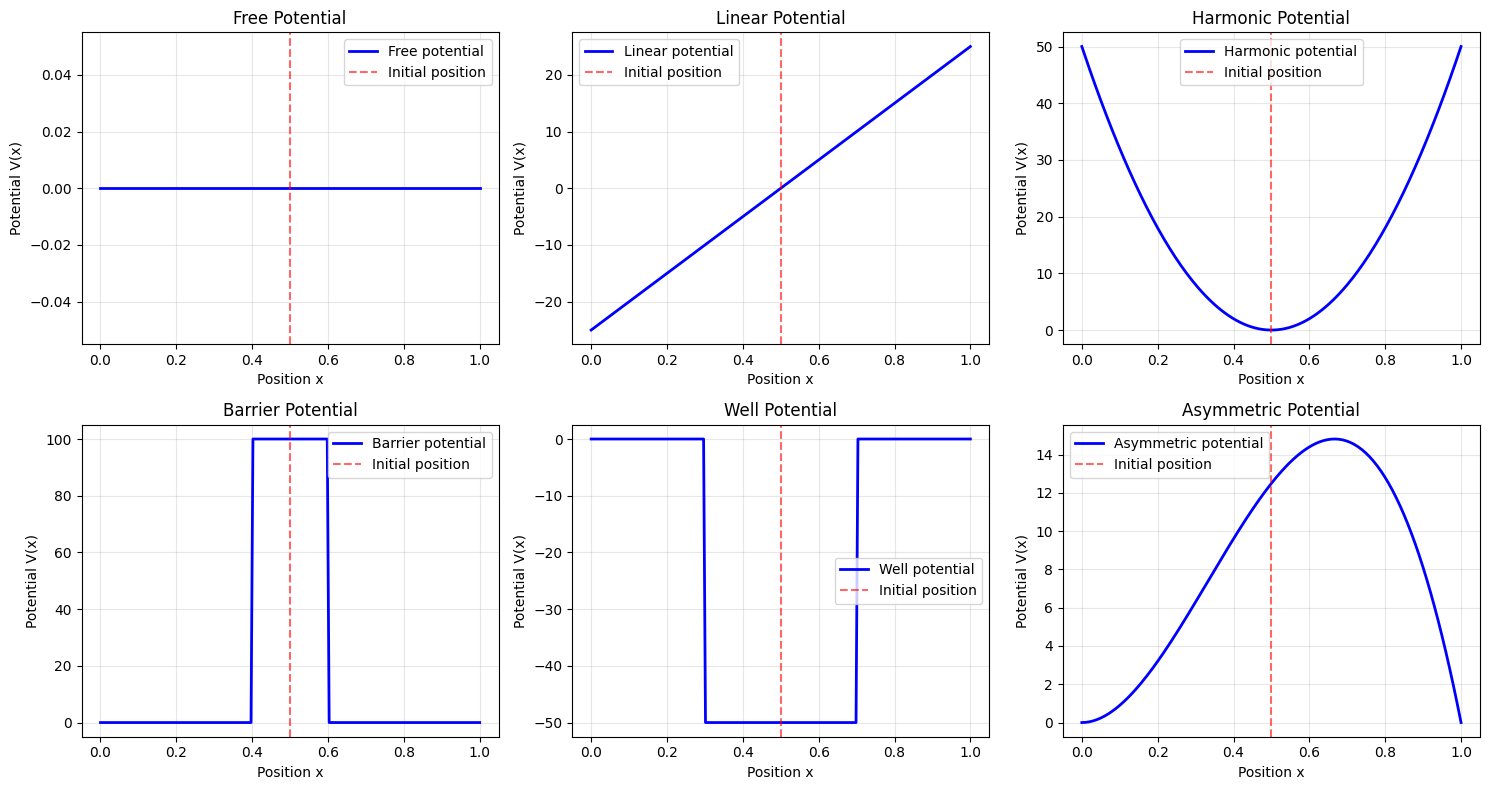

In [ ]:
# Plot all potential functions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (name, V) in enumerate(potentials.items()):
    axes[i].plot(x, V, 'b-', linewidth=2, label=f'{name} potential')
    axes[i].axvline(x=0.5, color='r', linestyle='--', alpha=0.6, label='Initial position')
    axes[i].set_xlabel('Position x')
    axes[i].set_ylabel('Potential V(x)')
    axes[i].set_title(f'{name} Potential')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

plt.tight_layout()
plt.show()

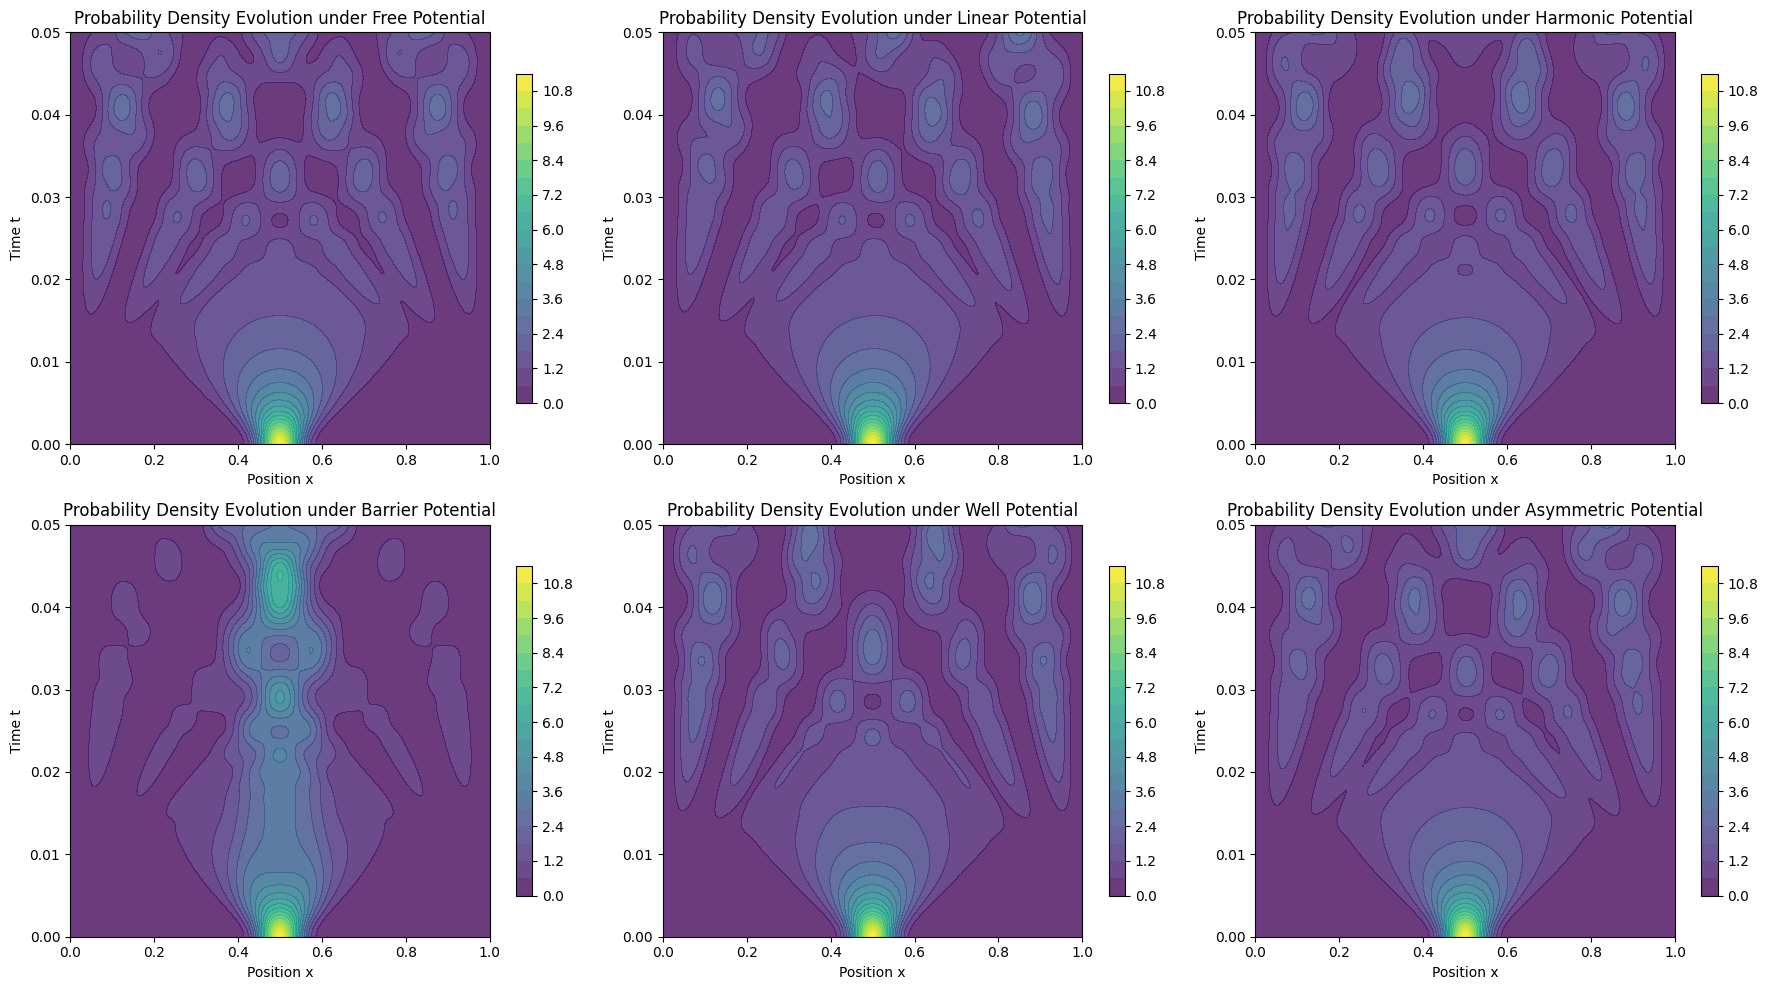

In [ ]:
# Plot heatmaps of wave function evolution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

t = np.linspace(0, t_final, num_t)
X, T = np.meshgrid(x, t, indexing='ij')

for i, (name, psi_t) in enumerate(results.items()):
    # Plot evolution of probability density |ψ|²
    prob_density = np.abs(psi_t)**2
    
    im = axes[i].contourf(X, T, prob_density, levels=20, cmap='viridis', alpha=0.8)
    axes[i].set_xlabel('Position x')
    axes[i].set_ylabel('Time t')
    axes[i].set_title(f'Probability Density Evolution under {name} Potential')
    plt.colorbar(im, ax=axes[i], shrink=0.8)

plt.tight_layout()
plt.show()

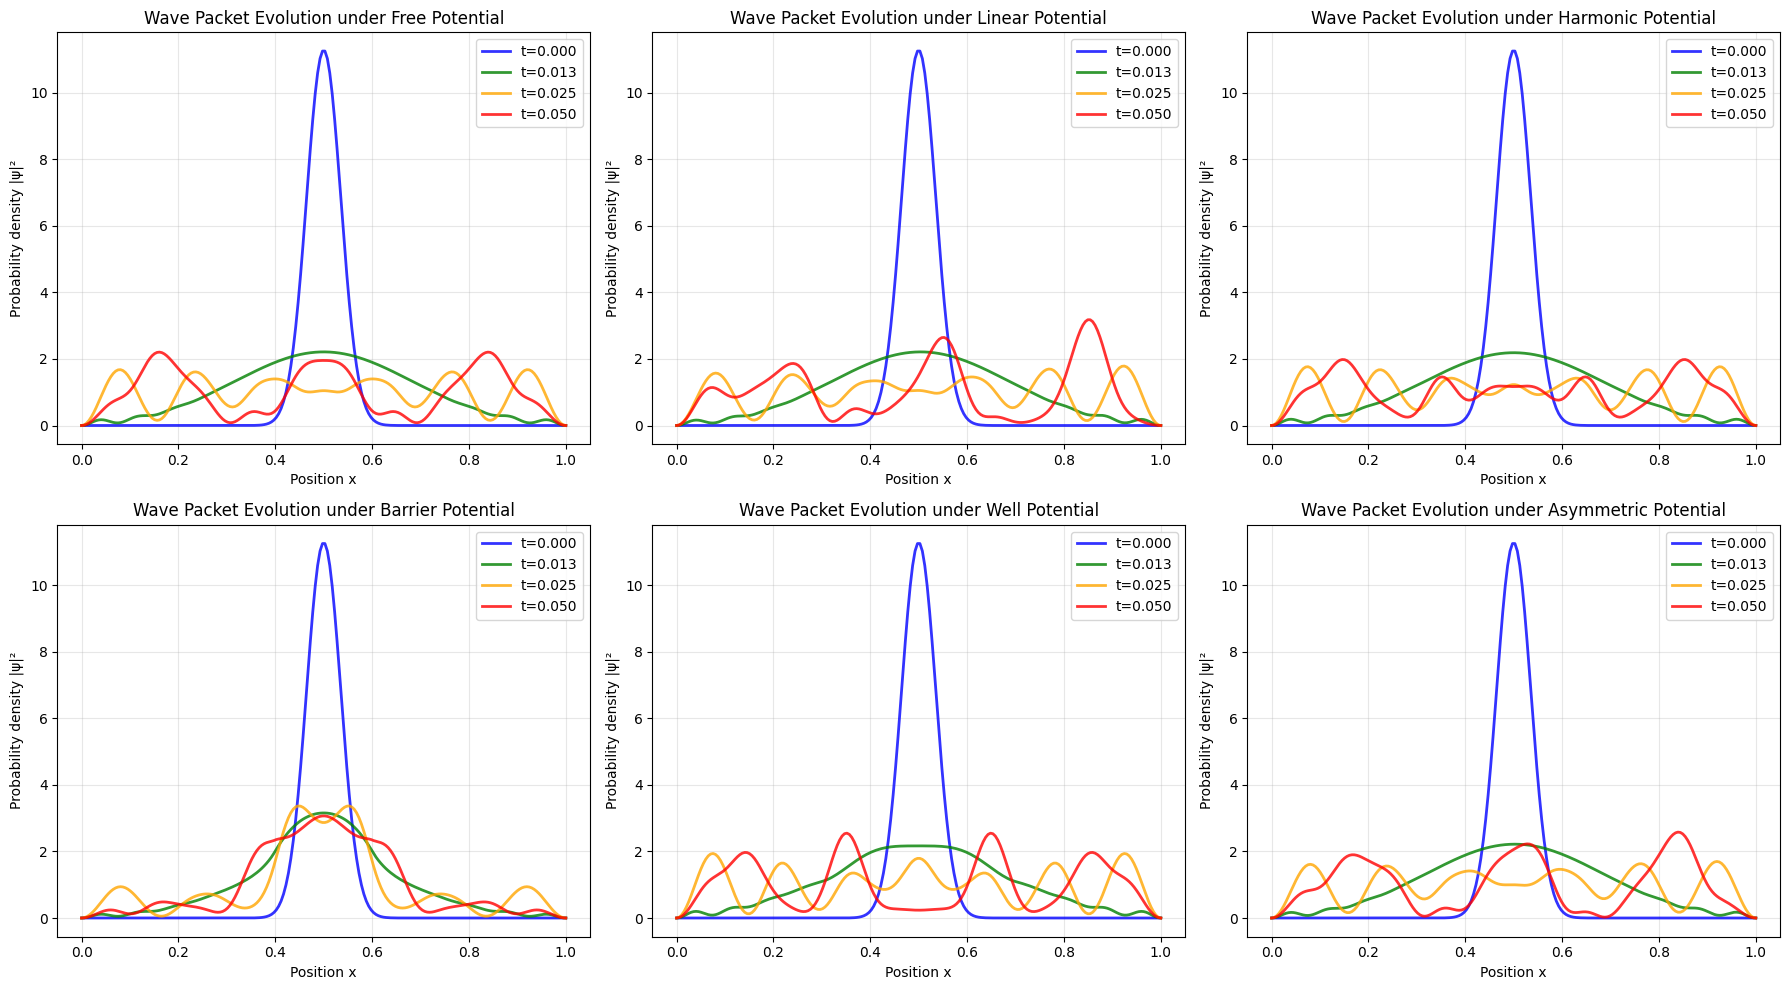

In [ ]:
# Plot wave function snapshots at specific times
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Select several time points
time_indices = [0, num_t//4, num_t//2, num_t-1]
colors = ['blue', 'green', 'orange', 'red']

for i, (name, psi_t) in enumerate(results.items()):
    for j, (t_idx, color) in enumerate(zip(time_indices, colors)):
        t_val = t_idx * t_final / (num_t - 1)
        prob = np.abs(psi_t[:, t_idx])**2
        axes[i].plot(x, prob, color=color, linewidth=2, 
                    label=f't={t_val:.3f}', alpha=0.8)
    
    axes[i].set_xlabel('Position x')
    axes[i].set_ylabel('Probability density |ψ|²')
    axes[i].set_title(f'Wave Packet Evolution under {name} Potential')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

plt.tight_layout()
plt.show()

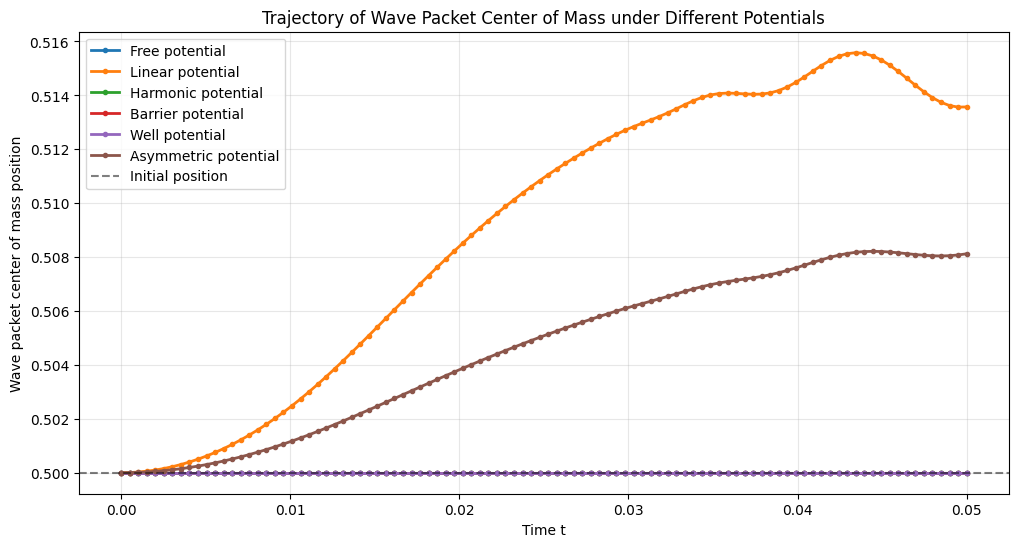

In [ ]:
# Analyze center of mass motion of wave packet
def analyze_motion(psi_t, x, t):
    """Analyze the change of wave packet center of mass over time"""
    center_of_mass = []
    for j in range(psi_t.shape[1]):
        prob = np.abs(psi_t[:, j])**2
        if np.sum(prob) > 1e-10:
            cm = np.trapz(x * prob, x) / np.trapz(prob, x)
            center_of_mass.append(cm)
        else:
            center_of_mass.append(np.nan)
    return np.array(center_of_mass)

# Analyze center of mass motion under all conditions
plt.figure(figsize=(12, 6))

t_array = np.linspace(0, t_final, num_t)
for name, psi_t in results.items():
    cm = analyze_motion(psi_t, x, t_array)
    plt.plot(t_array, cm, linewidth=2, label=f'{name} potential', marker='o', markersize=3)

plt.xlabel('Time t')
plt.ylabel('Wave packet center of mass position')
plt.title('Trajectory of Wave Packet Center of Mass under Different Potentials')
plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.5, label='Initial position')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Physical Phenomena Observations

Through the above demonstration, we can observe:

1. **Free particle**: Wave packet freely diffuses, center of mass remains at initial position
2. **Linear potential**: Wave packet moves toward lower potential energy region (classical force F = -dV/dx)
3. **Harmonic oscillator potential**: Wave packet oscillates in the potential well
4. **Potential barrier**: Wave packet undergoes reflection and transmission when encountering the barrier
5. **Potential well**: Wave packet is confined within the potential well
6. **Asymmetric potential**: Wave packet evolution is clearly asymmetric, reflecting the asymmetry of the potential

These results demonstrate both classical behavior and quantum effects of wave packets in different potential fields in quantum mechanics.

Testing modified _solve_schrodinger_pde from data_generation.py...
Modified to use random initial wavefunction in harmonic oscillator potential
Parameters: num_cal=200, length_scale=0.2, sigma=0.05


KeyboardInterrupt: 

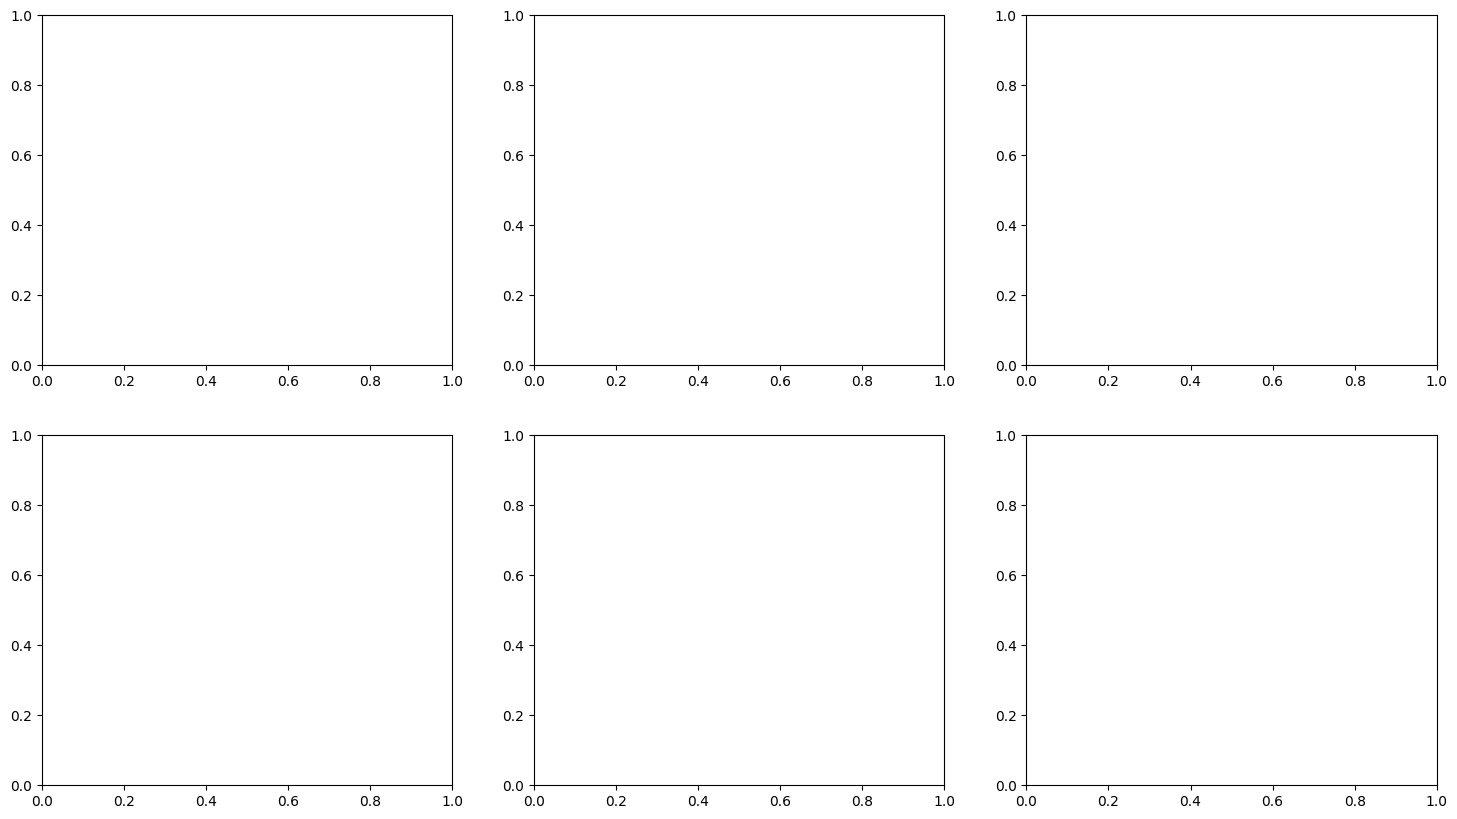

In [ ]:
# Test the modified _solve_schrodinger_pde function from data_generation.py
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('data_utils')
from data_generation import _solve_schrodinger_pde

# Test parameters
num_cal = 100
length_scale = 0.2
hbar = 1.0
m = 10
sigma = 0.05  # Now controls harmonic oscillator strength

print("Testing modified _solve_schrodinger_pde from data_generation.py...")
print("Modified to use random initial wavefunction in harmonic oscillator potential")
print(f"Parameters: num_cal={num_cal}, length_scale={length_scale}, sigma={sigma}")

# Test the function multiple times to see different random initial conditions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for test_idx in range(6):
    try:
        u_cal_prob, u0_cal = _solve_schrodinger_pde(num_cal, length_scale, hbar, m, sigma)
        print(f"Test {test_idx+1}: ✓ Success! Generated data shapes:")
        print(f"  Probability density evolution: {u_cal_prob.shape}")
        print(f"  Initial probability density: {u0_cal.shape}")
        print(f"  Evolution range: [{np.min(u_cal_prob):.6f}, {np.max(u_cal_prob):.6f}]")
        print(f"  Initial density range: [{np.min(u0_cal):.6f}, {np.max(u0_cal):.6f}]")
        
        # Calculate center of mass motion
        def analyze_motion(prob_density, x):
            """Calculate the center of mass over time"""
            center_of_mass = []
            for j in range(prob_density.shape[1]):
                prob = prob_density[:, j]
                if np.sum(prob) > 1e-10:
                    cm = np.trapz(x * prob, x) / np.trapz(prob, x)
                    center_of_mass.append(cm)
                else:
                    center_of_mass.append(np.nan)
            return np.array(center_of_mass)
        
        # Visualize this test case
        ax = axes[test_idx]
        
        # Plot probability density evolution (heatmap)
        x = np.linspace(0, 1, num_cal)
        t = np.linspace(0, 0.1, u_cal_prob.shape[1])  # Use actual time range
        X, T = np.meshgrid(x, t, indexing='ij')
        im = ax.contourf(X, T, u_cal_prob, levels=15, cmap='viridis', alpha=0.8)
        
        # Overlay center of mass trajectory
        cm = analyze_motion(u_cal_prob, x)
        ax.plot(cm, t, 'r-', linewidth=2, alpha=0.8, label='Center of mass')
        
        ax.set_xlabel('Position x')
        ax.set_ylabel('Time t')
        ax.set_title(f'Test {test_idx+1}: Random Initial ψ in Harmonic Potential')
        
        # Print center of mass statistics for this test
        print(f"  Center of mass displacement: {cm[-1] - cm[0]:.4f}")
        
    except Exception as e:
        print(f"Test {test_idx+1}: ✗ Error occurred: {e}")
        axes[test_idx].text(0.5, 0.5, f'Error in Test {test_idx+1}', 
                           ha='center', va='center', transform=axes[test_idx].transAxes)

plt.tight_layout()
plt.show()

# Test one case in detail with harmonic oscillator potential visualization
print("\n" + "="*60)
print("DETAILED ANALYSIS OF ONE CASE")
print("="*60)

try:
    u_cal_prob, u0_cal = _solve_schrodinger_pde(num_cal, length_scale, hbar, m, sigma)
    
    # Calculate the harmonic oscillator potential used
    omega = 50.0 * sigma
    x_cal = np.linspace(0, 1, num_cal)
    x0_potential = 0.5
    V_harmonic = 0.5 * m * (omega**2) * (x_cal - x0_potential)**2
    
    # Detailed visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot harmonic oscillator potential
    ax1.plot(x_cal, V_harmonic, 'b-', linewidth=2)
    ax1.plot(x_cal, u0_cal * np.max(V_harmonic) / np.max(u0_cal), 'r--', 
             linewidth=2, alpha=0.7, label='Initial |ψ₀|² (scaled)')
    ax1.set_xlabel('Position x')
    ax1.set_ylabel('Energy')
    ax1.set_title(f'Harmonic Oscillator Potential (ω={omega:.1f})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot probability density evolution (heatmap)
    X, T = np.meshgrid(x_cal, t, indexing='ij')
    im = ax2.contourf(X, T, u_cal_prob, levels=20, cmap='viridis')
    ax2.set_xlabel('Position x')
    ax2.set_ylabel('Time t')
    ax2.set_title('Probability Density Evolution |ψ(x,t)|²')
    plt.colorbar(im, ax=ax2)
    
    # Plot snapshots at different times
    time_indices = [0, u_cal_prob.shape[1]//4, u_cal_prob.shape[1]//2, -1]
    colors = ['blue', 'green', 'orange', 'red']
    for i, (t_idx, color) in enumerate(zip(time_indices, colors)):
        t_val = t_idx * 0.1 / (u_cal_prob.shape[1] - 1)
        prob = u_cal_prob[:, t_idx]
        ax3.plot(x_cal, prob, color=color, linewidth=2, 
                label=f't={t_val:.3f}', alpha=0.8)
    
    ax3.set_xlabel('Position x')
    ax3.set_ylabel('Probability density |ψ|²')
    ax3.set_title('Wave Function Evolution Snapshots')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # Plot center of mass motion
    cm = analyze_motion(u_cal_prob, x_cal)
    ax4.plot(t, cm, 'r-', linewidth=2, marker='o', markersize=3, label='Center of mass')
    ax4.axhline(y=0.5, color='k', linestyle='--', alpha=0.5, label='Potential center')
    ax4.set_xlabel('Time t')
    ax4.set_ylabel('Center of mass position')
    ax4.set_title('Wave Packet Center of Mass in Harmonic Oscillator')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    print(f"Detailed analysis results:")
    print(f"  Harmonic oscillator frequency ω = {omega:.2f}")
    print(f"  Potential depth at center: {V_harmonic[num_cal//2]:.4f}")
    print(f"  Initial center of mass: {cm[0]:.4f}")
    print(f"  Final center of mass: {cm[-1]:.4f}")
    print(f"  Center of mass oscillation amplitude: {(np.max(cm) - np.min(cm))/2:.4f}")
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"✗ Detailed analysis failed: {e}")
    import traceback
    traceback.print_exc()